<a href="https://colab.research.google.com/github/alicetrobinson/W266-project/blob/main/Moral_Text_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Text Classification with Convolutional Neural Networks

**Description:** This assignment covers various neural network architectures and components, largely used in the context of classification. You will compare Deep Averaging Networks, Convolutional Neural Networks, and BERT-based models. In part two, you should be able to develop an intuition for:


*   The effects of fine-tuning word vectors and over fitting the model
*   How various hyperparameters can help or hurt overfitting




The assignment notebook closely follows the lesson notebooks. We will use the IMDB dataset and will leverage some of the models, or part of the code, for our current investigation.

This notebook uses the Keras 3 functional API.  Make sure the correct versions get loaded.


<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup)
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Fix Convolutional Neural Net (CNN) Over Fitting](#modelCNN)


  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2025-spring-main/blob/master/assignment/a2/Text_classification_CNN.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally in your Colab environment.


In [ ]:
!pip install gensim --quiet

In [ ]:
!pip install tensorflow-datasets --quiet

In [ ]:
!pip install -U tensorflow-text --quiet

In [ ]:
!pip install pydot --quiet

In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00


Ready to do the imports.

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"


import numpy as np
import tensorflow as tf
import keras

from keras.layers import Embedding, Input, Dense, Lambda
from keras.models import Model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import tensorflow as tf

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [ ]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [ ]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [ ]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [ ]:
vec_model = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

In [ ]:
EMBEDDING_DIM = len(vec_model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(vec_model) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(vec_model.index_to_key):
    embedding_vector = vec_model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [ ]:
embedding_matrix.shape

(43982, 300)

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [ ]:
from datasets import load_dataset

# Load the dataset
moral_dataset = load_dataset("demelin/moral_stories", "cls-action+context+consequence-norm_distance")

# Select only the first 4000 for training and first 1000 for testing
moral_train_dataset = moral_dataset['train'].shuffle().select(range(20000))
moral_dev_dataset = moral_dataset['test'].shuffle().select(range(2000))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.0k [00:00<?, ?B/s]

moral_stories.py:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/3.70M [00:00<?, ?B/s]

(…)orm_distance%2Fvalidation%2F0000.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

(…)ence-norm_distance%2Ftest%2F0000.parquet:   0%|          | 0.00/374k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def preprocess_moral(data, tokenizer):
    merged_texts = []

    for moral, immoral in zip(data['moral_action'], data['immoral_action']):
        # Ignore "not specified" values for moral and immoral actions
        if moral.lower() == "not specified":
            action_text = immoral
        elif immoral.lower() == "not specified":
            action_text = moral
        else:
            action_text = f"{moral} {immoral}"  # Merge both sentences

        # Add the [CLS] token at the beginning, followed by situation, norm, and action_text, all separated by [SEP]
        #action_text = f"[CLS] {action_text} [SEP]"

        merged_texts.append(action_text)  # Store the merged text

    return tokenizer.tokenize(tf.constant(merged_texts))
    #return merged_texts


In [ ]:
train_tokens = preprocess_moral(moral_train_dataset, tf_text.WhitespaceTokenizer())
test_tokens = preprocess_moral(moral_dev_dataset, tf_text.WhitespaceTokenizer())

In [ ]:
train_labels = np.array(moral_train_dataset['label'])
test_labels = np.array(moral_dev_dataset['label'])

In [ ]:
train_labels[:4]

array([1, 1, 0, 0])

Does this look right?

In [ ]:
train_tokens[0]

<tf.Tensor: shape=(19,), dtype=string, numpy=
array([b'Lilith', b'announces', b'her', b'presence', b'to', b'her',
       b'friends', b'to', b'get', b'their', b'attention', b'and',
       b'inquires', b'as', b'to', b'the', b'topic', b'of', b'discussion.'],
      dtype=object)>

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [ ]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [ ]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [ ]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

#train_labels = np.array(train_labels)
#test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  1999


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [ ]:
train_tokens[:2]

<tf.RaggedTensor [[b'Lilith', b'announces', b'her', b'presence', b'to', b'her', b'friends',
  b'to', b'get', b'their', b'attention', b'and', b'inquires', b'as', b'to',
  b'the', b'topic', b'of', b'discussion.']                                 ,
 [b'Peter', b'investigates', b'closely', b'at', b'the', b'blades', b'of',
  b'grass', b'on', b'his', b'and', b"Stan's", b'lawn.']                  ]>

In [ ]:
train_input[:2]

array([[43981, 18729, 23245, 41759, 43981, 23245, 27361, 43981,  6541,
        32597,  9958, 43981, 43981, 12292, 43981, 14193, 25477, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [ ]:
train_labels[:4]

array([1, 1, 0, 0])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling




<a id = 'modelCNN'></a>
### 3.1 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [ ]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [ ]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 128, 300)       │     13,194,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 126, 100)       │         90,100 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 125, 100)       │        120,100 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 124, 50)        │         75,050 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 119, 25)        │         75,025 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 100)            │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 100)            │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 50)             │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 25)             │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 275)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 275)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100)            │         27,600 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50)             │          5,050 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             51 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,587,576 (51.83 MB)

 Trainable params: 392,976 (1.50 MB)

 Non-trainable params: 13,194,600 (50.33 MB)

The keras plot utility shows this probably a bit nicer:

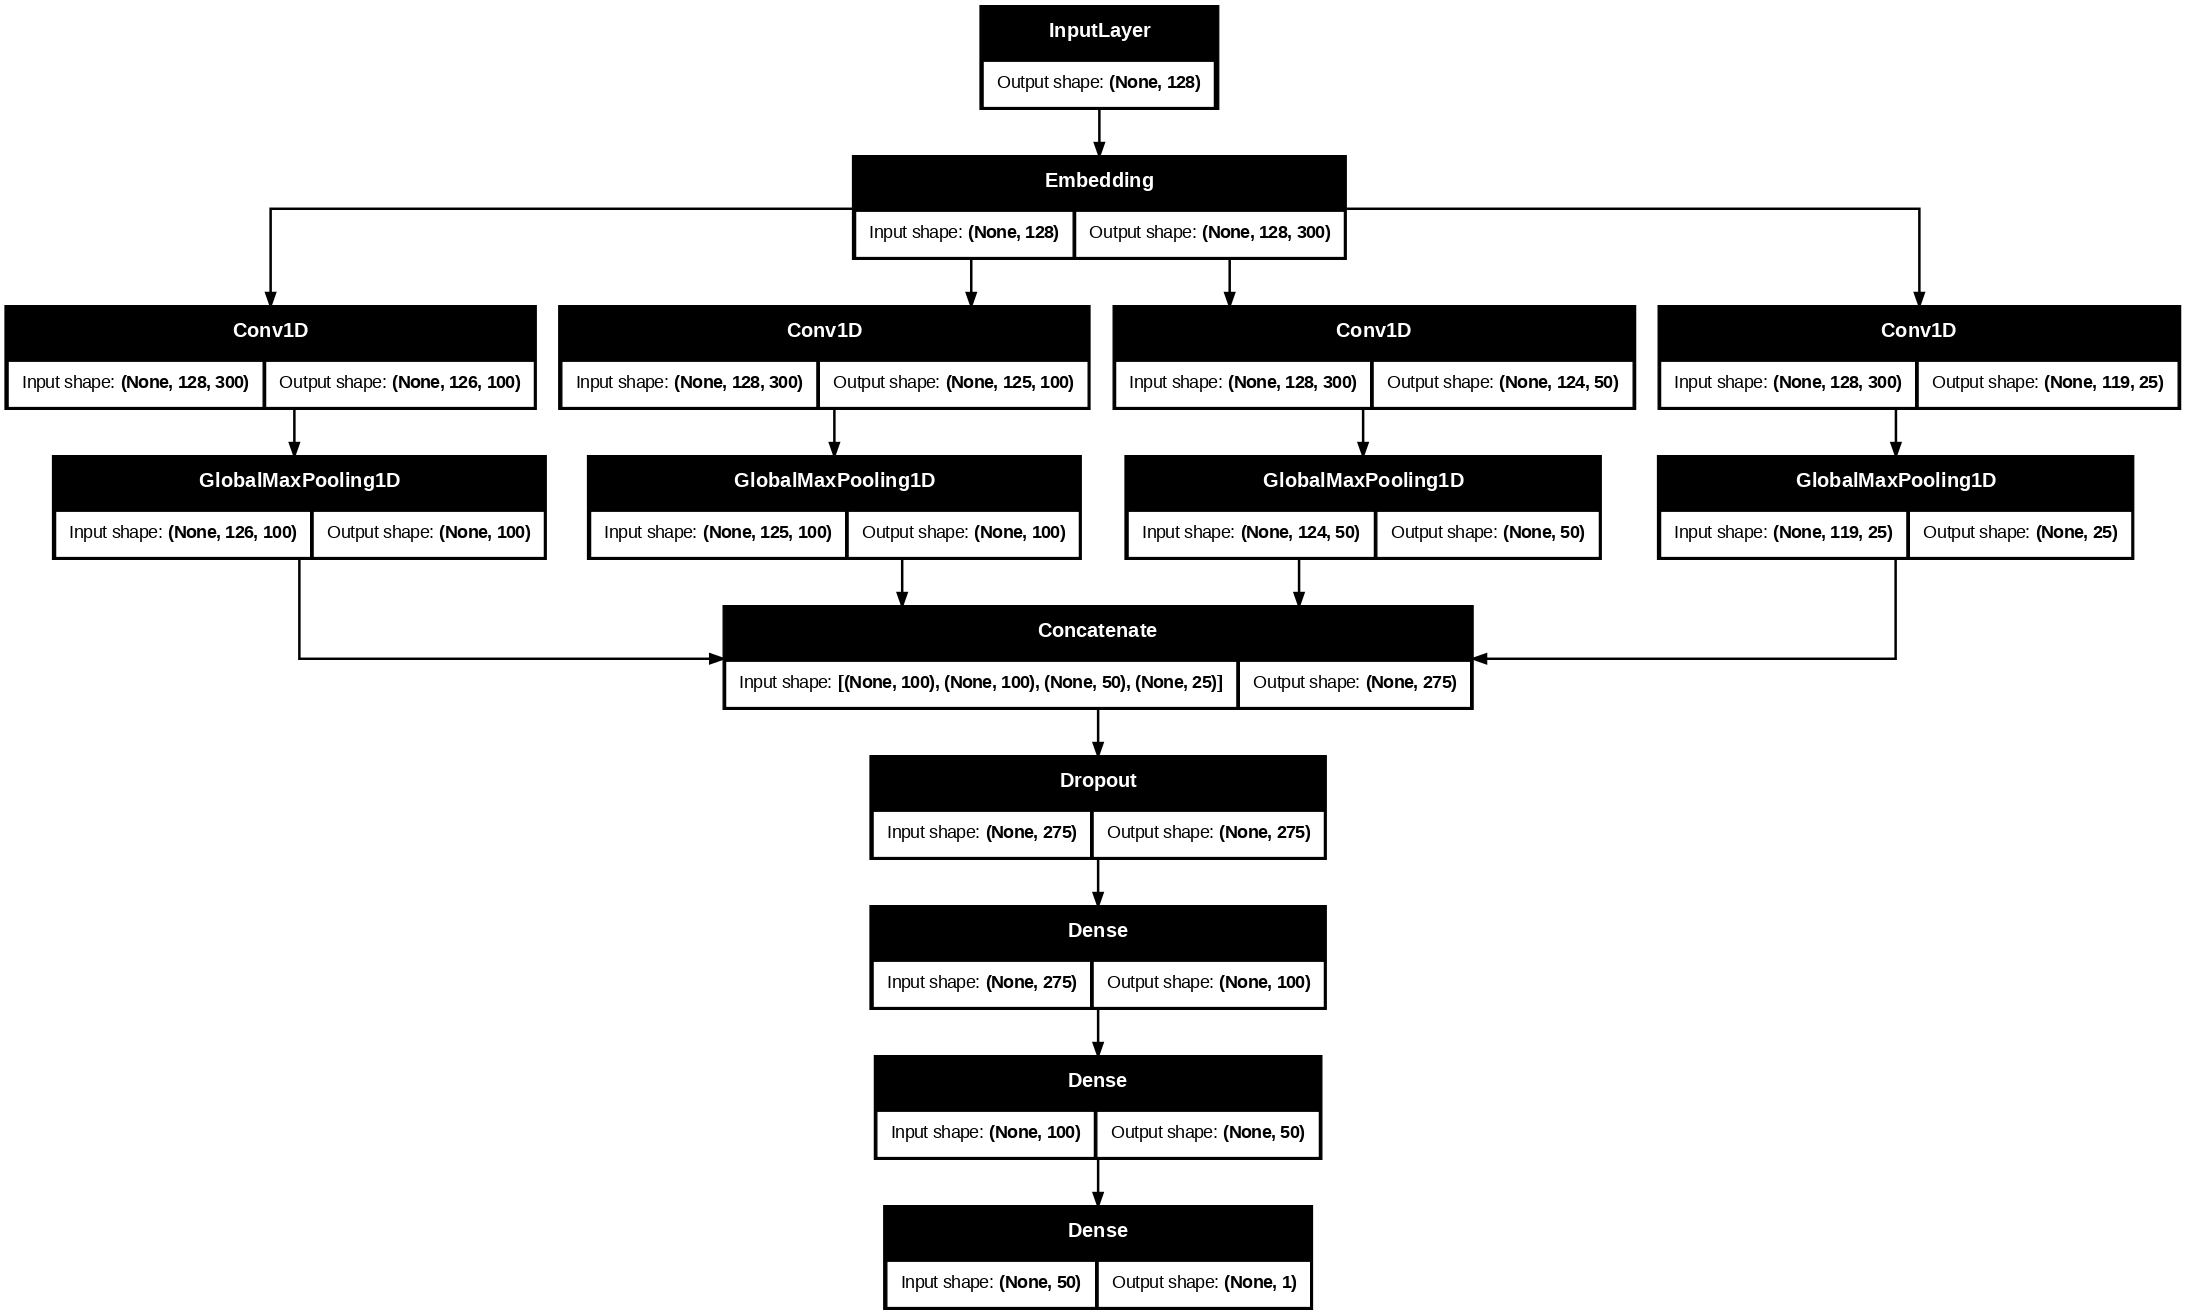

In [ ]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

Now let's train our CNN and see if it can learn without overfitting or underfitting.

In [ ]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5859 - loss: 0.6618 - val_accuracy: 0.6850 - val_loss: 0.5899
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7200 - loss: 0.5525 - val_accuracy: 0.6790 - val_loss: 0.5895
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7507 - loss: 0.5097 - val_accuracy: 0.6775 - val_loss: 0.5924
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7835 - loss: 0.4588 - val_accuracy: 0.7045 - val_loss: 0.5679
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8106 - loss: 0.4159 - val_accuracy: 0.6975 - val_loss: 0.6201
